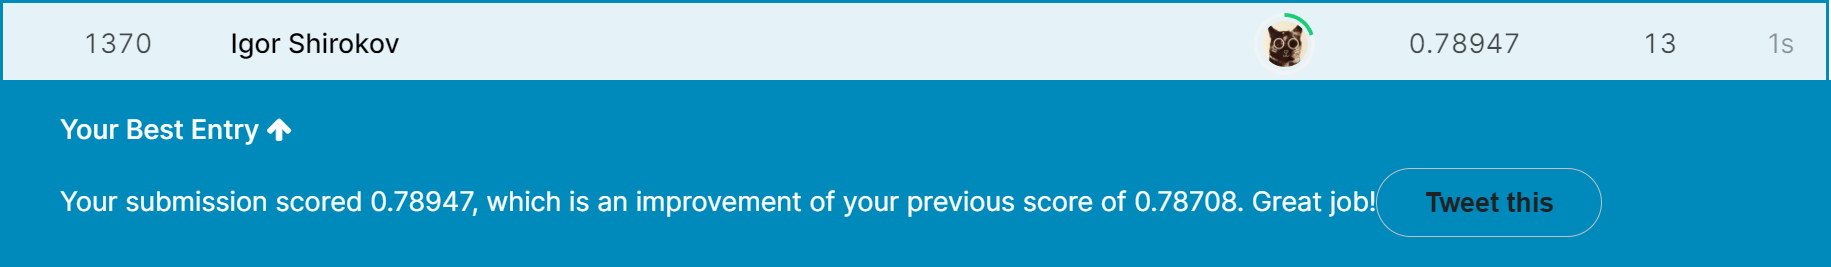

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import VotingClassifier

from scipy.stats import norm

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Function Declaration

In [2]:
# Fill NaN
def replace_func(df):
    df.replace({"Embarked" : {np.nan : "C"}}, inplace = True)

    for index, row in df.iterrows():
        if np.isnan(row['Age']):
            sub_row = median_age_grouped[(df.loc[index, 'title'] == median_age_grouped['title'])
                                          & (df.loc[index, 'Pclass'] == median_age_grouped['Pclass'])]
            
            df.loc[index, 'Age'] = sub_row['Age'].item()
    return df

In [3]:
# Find family_name and family_name from Name
def Name_func(row):
    row = row.replace('van ', '')
    row = row.replace('del ', '')
    row = row.replace('de ', '')
    row = row.replace('the ', '')
    split_1 = row.split(sep=', ', maxsplit=1)
    family_name = split_1[0]
    split_2 = split_1[1].split(sep=' ')
    title = split_2[0]
    return [family_name, title]

In [4]:
# Create additional features and shape existing ones
def EDA_func(df):
    
    # Combine all family members in a new column
    df['family_members_sum'] = df['SibSp'] + df['Parch']
    
    # Do bucketing with Age
    bins1 = [0, 5, np.median(df.Age)-10, np.median(df.Age)+10, 60, np.infty]
    labels1 = ['Infant', 'Teenager', 'Young', 'Mature', 'Old']
    df['group_Age'] = pd.cut(df.Age, bins=bins1, labels=labels1).copy()
    
    # Do bucketing with Fare
    bins2 = [0, np.median(df['Fare']), np.mean(df['Fare']), 100, np.infty]
    labels2 = ['Poor', 'Middle', 'Rich', 'Noble']
    df['group_Fare'] = pd.cut(df.Fare, bins=bins2, labels=labels2).copy()
    
    # Put passengers below 10 year old in the list
    kids_list = df[df['Age']<10]['title'].apply(lambda x: 'Kid')
    
    
    for index, row in df.iterrows():       
        # Specify group depending on how family affect survival rate
        if (row['family_members_sum'] < 4) & (row['Sex'] == "male"):
            df.loc[index, 'group_family'] = 'c' + str(row['family_members_sum'])
        else:
            df.loc[index, 'group_family'] = 'c_dead'
        
        if (row['family_members_sum'] < 4) & (row['Sex'] == "female"):
            df.loc[index, 'group_family'] = 'c4'
        else:
            df.loc[index, 'group_family'] = 'c1'
            
        # Group kids in title column
        if df.loc[index, 'Age'] < 10:
            df.loc[index, 'title'] = kids_list[index]

    return df

In [5]:
# Function to drop unneeded features
def drop_list(df):
    # Drop usless features
    df.drop(columns='Name', inplace=True)
    df.drop(columns='Ticket', inplace=True)
    df.drop(columns='SibSp', inplace=True)
    df.drop(columns='Parch', inplace=True)    
    
    # Drop Cabin - too many NaN
    df.drop(columns='Cabin', inplace=True)
    return df

# Import Data Set

In [6]:
# load train df and drop duplicates
train = pd.read_csv('train.csv')
train.drop_duplicates()
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

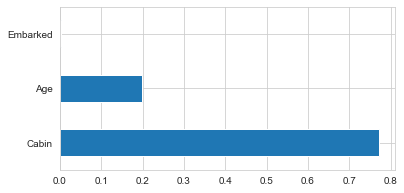

In [7]:
# Show NaN as % of missing values in the column
plt.figure(figsize=(6,3))
sns.set_style("whitegrid")
is_null_list = train.isnull().sum() / len(train)
is_null_list.sort_values(ascending=False, inplace=True)
is_null_list[is_null_list > 0].plot.barh()
plt.show()

In [8]:
# Find NaN in Embarked column
train[train['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [9]:
# Fair of this 2 survived passengers is big $80, so they probably embarked in C
train.groupby(['Embarked', 'Pclass'])['Fare'].median()

Embarked  Pclass
C         1         78.2667
          2         24.0000
          3          7.8958
Q         1         90.0000
          2         12.3500
          3          7.7500
S         1         52.0000
          2         13.5000
          3          8.0500
Name: Fare, dtype: float64

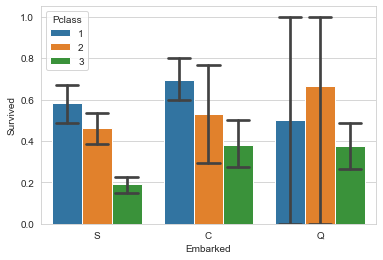

In [10]:
# PLot Embarked
ax = sns.barplot(data=train, x="Embarked", y="Survived", hue="Pclass", capsize=.2)
plt.show()

In [11]:
# Most passengers from Q was poor
train.groupby(['Embarked', 'Pclass'])['Survived'].count()

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
Name: Survived, dtype: int64

In [12]:
# Find family name and title
train[['family_name','title']] = list(train['Name'].apply(Name_func))

In [13]:
# Check what NaN we have inside title
train[train['Age'].isna()].groupby(['Age', 'title'], dropna=False)['Sex'].count()

Age  title  
NaN  Dr.          1
     Master.      4
     Miss.       36
     Mr.        119
     Mrs.        17
Name: Sex, dtype: int64

In [14]:
# Find how age depends from title, Pclass
median_age_grouped = pd.DataFrame(train.groupby(['title', 'Pclass'])['Age'].mean())
median_age_grouped.reset_index(inplace=True)
median_age_grouped

,title,Pclass,Age
0,Capt.,1,70.000000
1,Col.,1,58.000000
2,Countess.,1,33.000000
3,Don.,1,40.000000
4,Dr.,1,43.750000
5,Dr.,2,38.500000
6,Jonkheer.,1,38.000000
7,Lady.,1,48.000000
8,Major.,1,48.500000
9,Master.,1,5.306667


In [15]:
# See how many titles for passengers with age below 10
train[train['Age']<10].groupby(['title', 'Pclass'])['Age'].count()

title    Pclass
Master.  1          2
         2          9
         3         21
Miss.    1          1
         2          8
         3         21
Name: Age, dtype: int64

In [16]:
# Replace NaN
train = replace_func(train)

In [17]:
# Check NaN. We will drop Cabin because the is too many NaN
is_null_list = train.isna().sum() / len(train)
is_null_list[is_null_list>0]

Cabin    0.771044
dtype: float64

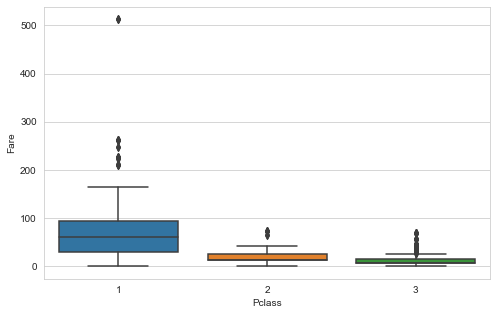

In [18]:
# Let's see how Fare connected with Placass
plt.figure(figsize=(8,5))
sns.boxplot(data=train, y='Fare', x='Pclass')
plt.show()

In [19]:
# Fare and Survivability rate
bins = [0, np.median(train['Fare']), np.mean(train['Fare']), 100, np.infty]
train.groupby(pd.cut(train.Fare, bins)).mean()['Survived']

Fare
(0.0, 14.454]       0.256944
(14.454, 32.204]    0.446352
(32.204, 100.0]     0.550633
(100.0, inf]        0.735849
Name: Survived, dtype: float64

In [20]:
# Age and Survivability rate
bins = [0, 5, np.median(train.Age)-10, np.median(train.Age)+10, 60, np.infty]
train.groupby(pd.cut(train.Age, bins)).mean()['Survived']

Age
(0.0, 5.0]          0.704545
(5.0, 18.725]       0.454545
(18.725, 38.725]    0.337917
(38.725, 60.0]      0.402174
(60.0, inf]         0.227273
Name: Survived, dtype: float64

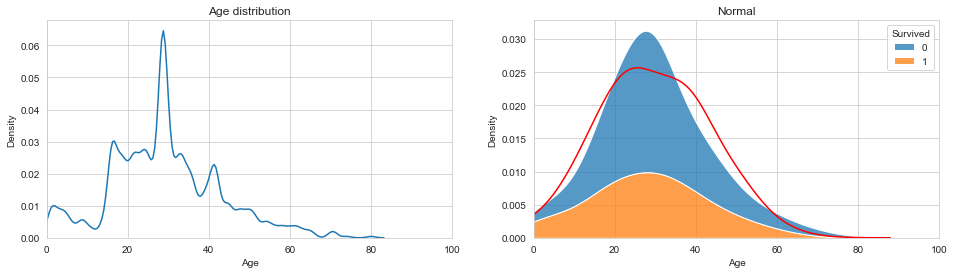

In [21]:
# See how Age affect Survivability 
fig, axes = plt.subplots(1, 2, figsize=(16,4), sharex=True)

loc1, scale1 = norm.fit(train.Age)
r = norm.rvs(loc1, scale1, size=1000)
sns.kdeplot(data=r, ax=axes[1], bw_adjust=1.5, color='red')

sns.kdeplot(x=train.Age, bw_adjust=.3, ax=axes[0])
sns.kdeplot(x=train.Age, hue=train.Survived, multiple="stack", bw_adjust=1.5, ax=axes[1])

axes[0].set_title('Age distribution')
axes[1].set_title('Normal')
plt.xlim(0,100)
plt.show()

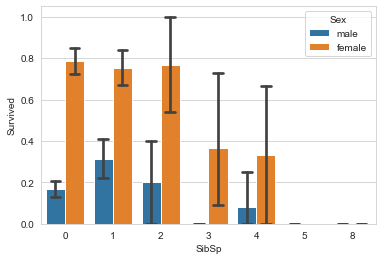

In [22]:
# Drow number of siblings / spouses aboard the Titanic
ax = sns.barplot(data=train, x="SibSp", y="Survived", hue="Sex", capsize=.2)
plt.show()

In [23]:
train[train['SibSp']>2].groupby(['SibSp', 'Sex'])['Age'].count()

SibSp  Sex   
3      female    11
       male       5
4      female     6
       male      12
5      female     1
       male       4
8      female     3
       male       4
Name: Age, dtype: int64

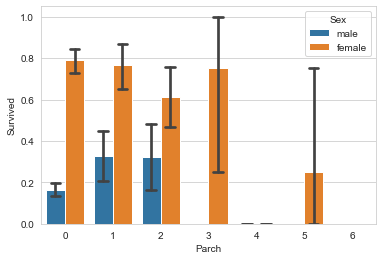

In [24]:
# Drow number of parents / children aboard the Titanic
ax = sns.barplot(data=train, x="Parch", y="Survived", hue="Sex", capsize=.2)
plt.show()

In [25]:
train[train['Parch']>2].groupby(['Parch', 'Sex'])['Age'].count()

Parch  Sex   
3      female    4
       male      1
4      female    2
       male      2
5      female    4
       male      1
6      female    1
Name: Age, dtype: int64

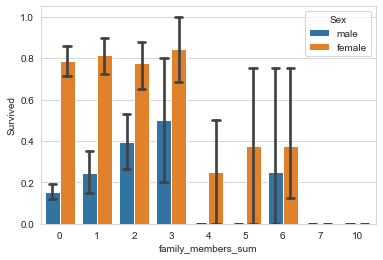

In [26]:
# Let's see how family on board affect survivability
train['family_members_sum'] = train['SibSp'] + train['Parch']
ax = sns.barplot(data=train, x="family_members_sum", y="Survived", hue="Sex", capsize=.2)
plt.show()

# Model Development | Preparations

In [27]:
# load df's
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Drop the  'PassengerId' colum since it's unnecessary for the prediction process
train.drop(['PassengerId'], axis=1, inplace=True)
test.drop(['PassengerId'], axis=1, inplace=True)

In [28]:
# Define features and target variable
y = train.Survived.reset_index(drop=True)
train_features = train.drop('Survived', axis=1)
test_features = test
features = train_features.append(test_features, sort=False)
features.reset_index(inplace=True)
features = features.drop('index', axis=1)
features.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Apply functions

In [29]:
features[['family_name','title']] = list(features['Name'].apply(Name_func))

In [30]:
median_age_grouped = pd.DataFrame(features.groupby(['title', 'Pclass'])['Age'].median())
median_age_grouped.reset_index(inplace=True)
median_age_grouped[median_age_grouped['Age'].isna()]

,title,Pclass,Age
25,Ms.,3,NaN


In [31]:
median_age_grouped = median_age_grouped.replace(np.nan, 28)
features = replace_func(features)

In [32]:
features.groupby('title')['Sex'].count().sort_values(ascending=False)

title
Mr.          757
Miss.        260
Mrs.         197
Master.       61
Rev.           8
Dr.            8
Col.           4
Mlle.          2
Ms.            2
Major.         2
Mme.           1
Capt.          1
Lady.          1
Jonkheer.      1
Dona.          1
Don.           1
Countess.      1
Sir.           1
Name: Sex, dtype: int64

In [33]:
remap_title_dict = {
    'Mr.': 'Mr.',
    'Miss.': 'Miss.',
    'Mrs.': 'Mrs.',
    
    'Sir.': 'Mr.',
    'Don.': 'Mr.',
    
    'Mlle.': 'Miss.',
    'Ms.': 'Miss.',
    'Mme.': 'Miss.',
    'Lady.': 'Mrs.',
    'Dona.': 'Mrs.',
    'Countess.': 'Miss.'
}
features.title = features.title.map(remap_title_dict)
features['title'] = features['title'].replace(np.nan, 'Other')

In [34]:
# Check NaN
is_null_list = features.isna().sum() / len(features)
is_null_list[is_null_list>0]

Fare     0.000764
Cabin    0.774637
dtype: float64

In [35]:
# Find NaN in Embarked column
features[features['Fare'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,family_name,title
1043,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Storey,Mr.


In [36]:
features['Fare'] = features['Fare'].replace(np.nan, 8)

In [37]:
features = EDA_func(features)

In [38]:
# We use the numpy fuction log1p which applies log(1+x) to all elements of the column
features["Age"] = np.log1p(features["Age"])
features["Fare"] = np.log1p(features["Fare"])

In [39]:
features = drop_list(features)

In [40]:
features.head()

,Pclass,Sex,Age,Fare,Embarked,family_name,title,family_members_sum,group_Age,group_Fare,group_family
0,3,male,3.135494,2.110213,S,Braund,Mr.,1,Young,Poor,c1
1,1,female,3.663562,4.280593,C,Cumings,Mrs.,1,Mature,Rich,c4
2,3,female,3.295837,2.188856,S,Heikkinen,Miss.,0,Young,Poor,c4
3,1,female,3.583519,3.990834,S,Futrelle,Mrs.,1,Young,Rich,c4
4,3,male,3.583519,2.202765,S,Allen,Mr.,0,Young,Poor,c1


In [41]:
features.groupby('title')['Sex'].count().sort_values(ascending=False)

title
Mr.      759
Miss.    227
Mrs.     199
Kid       90
Other     34
Name: Sex, dtype: int64

In [42]:
# Get dummies
final_features = pd.get_dummies(features,).reset_index(drop=True)
X = final_features.iloc[:len(train), :]
X_sub = final_features.iloc[len(y):, :]
X.shape

(891, 900)

In [43]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)

In [44]:
X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

In [45]:
X.shape

(891, 692)

# Model Development | Final Estimation and Prediction

In [46]:
# Sclit the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

## Classifiers

In [47]:
r1 = LogisticRegression(max_iter=100, solver='liblinear', random_state=38)
pipe = Pipeline([('StandardScaler', preprocessing.StandardScaler()), ('clf', r1)])
cv = cross_validate(pipe, X, y, cv=5, n_jobs=-1)
cv['test_score']

array([0.78212291, 0.82022472, 0.8258427 , 0.80337079, 0.85393258])

In [48]:
r2 = GradientBoostingClassifier(n_estimators=1000, random_state=38)
pipe = Pipeline([('StandardScaler', preprocessing.StandardScaler()), ('clf', r2)])
cv = cross_validate(pipe, X, y, cv=5, n_jobs=-1)
cv['test_score']

array([0.84357542, 0.83146067, 0.84269663, 0.80898876, 0.85393258])

In [49]:
r3 = AdaBoostClassifier(n_estimators=120, random_state=38)
pipe = Pipeline([('StandardScaler', preprocessing.StandardScaler()), ('clf', r3)])
cv = cross_validate(pipe, X, y, cv=5, n_jobs=-1)
cv['test_score']

array([0.81005587, 0.83146067, 0.82022472, 0.81460674, 0.82022472])

In [50]:
r4 = BaggingClassifier(n_estimators=65, max_features=300, random_state=38)
pipe = Pipeline([('StandardScaler', preprocessing.StandardScaler()), ('clf', r4)])
cv = cross_validate(pipe, X, y, cv=5, n_jobs=-1)
cv['test_score']

array([0.81564246, 0.83707865, 0.85393258, 0.80898876, 0.83146067])

In [51]:
r5 = RandomForestClassifier(random_state=38, criterion='entropy')
pipe = Pipeline([('StandardScaler', preprocessing.StandardScaler()), ('clf', r5)])
cv = cross_validate(pipe, X, y, cv=5, n_jobs=-1)
cv['test_score']

array([0.83798883, 0.8258427 , 0.84269663, 0.80337079, 0.83146067])

In [52]:
# Final Voting Classifier
v_reg = VotingClassifier([
    ('r1', r1),
    ('r2', r2),
    # ('r3', r3),
    # ('r4', r4),
    ('r5', r5),
])

In [53]:
# Form a pipeline
pipe = Pipeline([
    ('scaler', preprocessing.RobustScaler()),
    ('classifier', v_reg)
])

In [54]:
cv = cross_validate(pipe, X, y, cv=5, n_jobs=-1)
cv['test_score']

array([0.83798883, 0.84269663, 0.83707865, 0.80898876, 0.83707865])

In [55]:
pipe.fit(X_train, y_train).score(X_test, y_test)

0.8491620111731844

In [56]:
# Make a prediction
target_variable = pipe.fit(X, y).predict(X_sub)

# Save results

In [57]:
prediction = pd.DataFrame()

index_n = np.linspace(892, 1309, 418)
prediction['PassengerId'] = index_n
prediction['PassengerId'] = prediction['PassengerId'].astype('int')

In [58]:
prediction['Survived'] = target_variable.astype('int')
prediction.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [59]:
file_name = 'Prediction-' + str(datetime.date.today()) + '.csv'
pd.DataFrame(prediction).to_csv(file_name, index=False)
print('Saved!')